In [1]:
%matplotlib inline
from utils import *
from tqdm import *
from os.path import join
from matplotlib import pyplot as plt
from skimage.measure import block_reduce
from multiprocessing import Pool
import numpy as np
import librosa
from tqdm import tqdm

from time import time
import matplotlib.cm as cm
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
data_root = 'drumData'
n_fft = 1024
hop_length = n_fft/4
use_logamp = False # boost the brightness of quiet sounds
reduce_rows = 10 # how many frequency bands to average into one
reduce_cols = 1 # how many time steps to average into one
crop_rows = 32 # limit how many frequency bands to use
crop_cols = 32 # limit how many time steps to use
limit = None # set this to 100 to only process 100 samples

drumNames = ["kick", "tom", "snare", "clap", "hi.hat", "ride", "crash"]
drumFingerPrints = {}
drumSamples = {}
for d in drumNames:
    %time drumSamples[d] = np.load(join(data_root, d+'_samples.npy'))

CPU times: user 1.6 ms, sys: 255 ms, total: 256 ms
Wall time: 264 ms
CPU times: user 861 µs, sys: 19.9 ms, total: 20.8 ms
Wall time: 27.8 ms
CPU times: user 1.15 ms, sys: 124 ms, total: 125 ms
Wall time: 150 ms
CPU times: user 2.02 ms, sys: 65.9 ms, total: 67.9 ms
Wall time: 84.6 ms
CPU times: user 1.13 ms, sys: 9.51 ms, total: 10.6 ms
Wall time: 18 ms
CPU times: user 882 µs, sys: 10.8 ms, total: 11.7 ms
Wall time: 45.4 ms
CPU times: user 1.02 ms, sys: 36 ms, total: 37 ms
Wall time: 53.7 ms


# Load 6x24 MIR features

In [3]:
x_data_MIR = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_MIRfeatures.npy'
    drum_features = np.load(file_path)
    print(drum_features.shape)
    x_data_MIR.extend(drum_features)
x_data_MIR = np.asarray(x_data_MIR)
print("x_data_MIR.shape:", x_data_MIR.shape)
x_data_MIR = x_data_MIR.reshape(len(x_data_MIR),-1)
print("x_data_MIR.shape:", x_data_MIR.shape)

(5158, 6, 24)
(422, 6, 24)
(2546, 6, 24)
(1324, 6, 24)
(159, 6, 24)
(228, 6, 24)
(723, 6, 24)
('x_data_MIR.shape:', (10560, 6, 24))
('x_data_MIR.shape:', (10560, 144))


# Load 32x32 STFT features

In [4]:
import pickle
data_root = 'drumData/'
initial_dims = [30]
perplexities = [30]
mode = 'fingerprints'
drumNames = pickle.load(open(data_root+'drumNames.pickle'))
drumLengths = pickle.load(open(data_root+'drumLengths.pickle'))

drumPrints = []
drumLabels = []
for i, drum in enumerate(drumNames):
    STFT_feat = np.load(join(data_root, drum+'_fingerprints.npy'))
    drumPrints.extend(STFT_feat)
    drumLabels.extend([i] * STFT_feat.shape[0])

x_data_STFT = np.asarray(drumPrints)
print("x_data_STFT.shape:", x_data_STFT.shape)
x_data_STFT = x_data_STFT.reshape(len(x_data_STFT),-1)
print("x_data_STFT.shape:", x_data_STFT.shape)

('x_data_STFT.shape:', (10560, 32, 32))
('x_data_STFT.shape:', (10560, 1024))


In [5]:
import itertools
def concatColors(segmentList, colorList):
    multiples = []
    #print segmentList, colorList
    for i in range(len(segmentList)):
        multiples.append([colorList[i]]*segmentList[i])
    return list(itertools.chain(*multiples))

colors = ['#000000', '#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '#00ffff']
drumLengths = [5158,422,2546,1324,159,228,723]
colorMap = concatColors(drumLengths, colors)

# Load MFCC features 30x24

In [26]:
x_data_MFCC = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_MFCCs.npy'
    drum_features = np.load(file_path)
    x_data_MFCC.extend(drum_features)
x_data_MFCC = np.asarray(x_data_MFCC)
print("x_data_MFCC.shape:", x_data_MFCC.shape)
x_data_MFCC = x_data_MFCC.reshape(len(x_data_MFCC),-1)
print("x_data_MFCC.shape:", x_data_MFCC.shape)

('x_data_MFCC.shape:', (10560, 30, 24))
('x_data_MFCC.shape:', (10560, 720))


# Load Wavenet features 23x16

In [29]:
x_data_Wavenet = []
for drumName in drumNames: 
    file_path = './drumData/' + drumName + '_wavenet.npy'
    drum_features = np.load(file_path)
    x_data_Wavenet.extend(drum_features)
x_data_Wavenet = np.asarray(x_data_Wavenet)
print("x_data_Wavenet.shape:", x_data_Wavenet.shape)
x_data_Wavenet = x_data_Wavenet.reshape(len(x_data_Wavenet),-1)
print("x_data_Wavenet.shape:", x_data_Wavenet.shape)

('x_data_Wavenet.shape:', (10560, 23, 16))
('x_data_Wavenet.shape:', (10560, 368))


# Create ground truth labels

('y_data.shape:', (10560,))


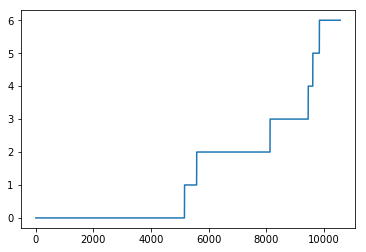

In [7]:
drumLabels = []
for i, drum in enumerate(drumNames):
    STFT_feat = np.load(join(data_root, drum+'_fingerprints.npy'))
    drumPrints.extend(STFT_feat)
    drumLabels.extend([i] * STFT_feat.shape[0])
y_data = np.asarray(drumLabels)
print("y_data.shape:", y_data.shape)
plt.figure()
plt.plot(y_data)

# Plot data in 2D PCA space

In [31]:
def plotPCA2D(data_X, data_Y, title):
    # #############################################################################
    # Visualize the results on PCA-reduced data
    np.random.seed(42)
    data = data_X

    n_samples, n_features = data.shape
    #n_digits = len(np.unique(digits.target))
    n_digits = 7
    labels = data_Y

    reduced_data = PCA(n_components=2).fit_transform(data)
    kmeans = KMeans(init='random', n_clusters=n_digits, n_init=10)
    kmeans.fit(reduced_data)
    
    #plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1],c=colorMap,s=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the drumset dataset (Top 2 PCA-reduced data)\n'
              'Centroids are marked with white cross\n' +
                title)
    plt.xticks(())
    plt.yticks(())
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()
    
def computeSilCoeff(data, cluster_labels):
    redu_data = PCA(n_components=2).fit_transform(data)
    print("original data dim:", data.shape)
    print("reduced data dim:", redu_data.shape)
    silhouette_avg = silhouette_score(redu_data, cluster_labels)
    print("The average silhouette_score is :", silhouette_avg)

def plotSampleSilCoeff(data, cluster_labels, title):
    fig, ax1 = plt.subplots()
    silhouette_avg = silhouette_score(data, cluster_labels)
    sample_silhouette_values = silhouette_samples(data, cluster_labels)
    
    n_clusters = 7
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# Plotting data points in 2D PCA space

### Plotting clustering results using MIR Features

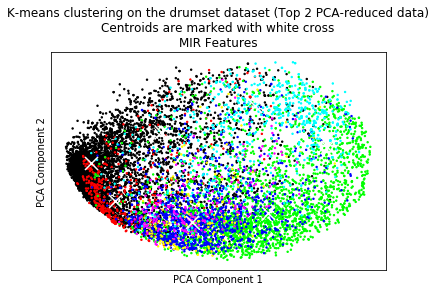

In [9]:
plotPCA2D(x_data_MIR,y_data,"MIR Features")

In [10]:
computeSilCoeff(x_data_MIR,y_data)

('original data dim:', (10560, 144))
('reduced data dim:', (10560, 2))
('The average silhouette_score is :', -0.034992608949570604)


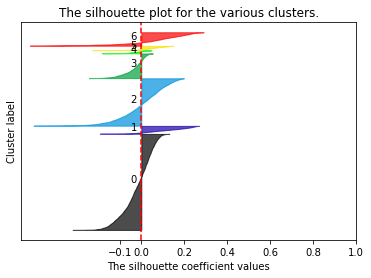

In [11]:
plotSampleSilCoeff(x_data_MIR,y_data,"MIR Features")

### Plotting clustering results using STFT Features

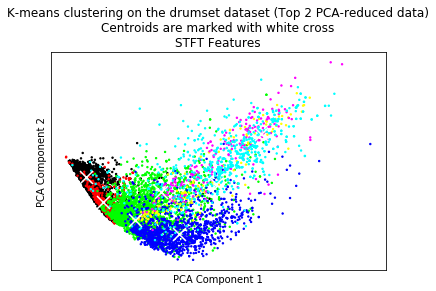

In [12]:
plotPCA2D(x_data_STFT,y_data,"STFT Features")

In [13]:
computeSilCoeff(x_data_STFT,y_data)

('original data dim:', (10560, 1024))
('reduced data dim:', (10560, 2))
('The average silhouette_score is :', 0.11460269)


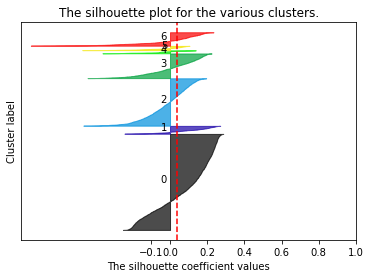

In [14]:
plotSampleSilCoeff(x_data_STFT,y_data,"STFT Features")

### Plotting clustering results using MFCC Features

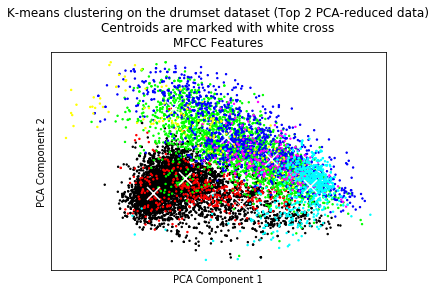

In [15]:
plotPCA2D(x_data_MFCC,y_data,"MFCC Features")

In [16]:
computeSilCoeff(x_data_MFCC,y_data)

('original data dim:', (10560, 720))
('reduced data dim:', (10560, 2))
('The average silhouette_score is :', -0.010438017789522323)


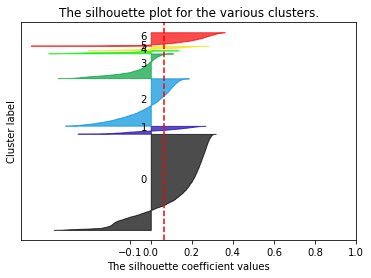

In [17]:
plotSampleSilCoeff(x_data_MFCC,y_data,"MFCC Features")

### Plotting clustering results using Wavenet Features

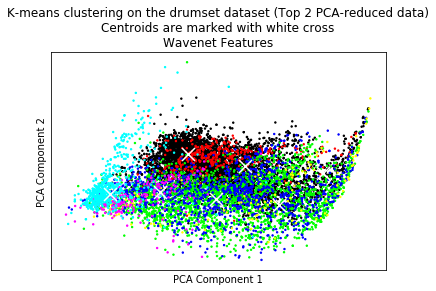

In [32]:
plotPCA2D(x_data_Wavenet,y_data,"Wavenet Features")

In [33]:
computeSilCoeff(x_data_Wavenet,y_data)

('original data dim:', (10560, 368))
('reduced data dim:', (10560, 2))
('The average silhouette_score is :', -0.10251355)


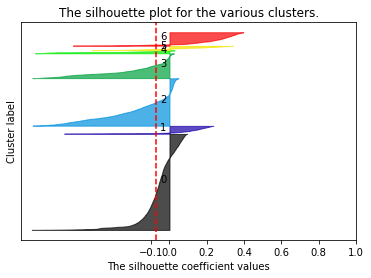

In [34]:
plotSampleSilCoeff(x_data_Wavenet,y_data,"Wavenet Features")

# Geometric Metrics

In [8]:
import numpy as np
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, MultiPolygon, Point

In [23]:
def clusterGeometryMetrics(drum_points, labels):
    
    grouped_drum_points = {}
    
    for i in range(len(drum_points)):
        if labels[i] not in grouped_drum_points:
            grouped_drum_points[labels[i]] = list()
        grouped_drum_points[labels[i]].append(drum_points[i])
    
    num_labels = len(grouped_drum_points)
    drum_polygons = {}
    
    for drum in grouped_drum_points:
        points = grouped_drum_points[drum]
        hull = ConvexHull(grouped_drum_points[drum])
        drum_polygons[drum] = Polygon([points[v] for v in hull.vertices])
    
    total_hull = ConvexHull(drum_points)
    total_polygon = Polygon([drum_points[v] for v in total_hull.vertices])
    p = [Point(c) for c in total_polygon.exterior.coords]
    total_diameter = max([p1.distance(p2) for p1 in p for p2 in p])
    
    calc_intersect = lambda i, j: drum_polygons[i].intersection(drum_polygons[j]).area / total_polygon.area
    calc_roundness = lambda poly : 4 * np.pi * poly.area / (poly.length**2)
    calc_distance = lambda i, j: drum_polygons[i].distance(drum_polygons[j]) / total_diameter
    
    #overlap areas between the polygons of the different clusters, normalized by area of total plot polygon
    pairwise_intersect_areas = [[calc_intersect(i,j) for i in range(num_labels)] for j in range(num_labels)]
    
    
    # Distance between nearest points of 2 polygons normalized by "diameter" of total plot polygon
    pairwise_distances = [[calc_distance(i,j) for i in range(num_labels)] for j in range(num_labels)]
    
    #measure of "roundness" of each polygon based on Polsby-Popper Test
    roundness = [calc_roundness(drum_polygons[d]) for d in drum_polygons]
    
    #relative sizes of each cluster polygon normalized by area of total plot polygon
    relative_areas = [drum_polygons[d].area / total_polygon.area for d in drum_polygons]
    
    #the polygons themselves for further processing 
    polygons = drum_polygons.values() + [total_polygon]
    
    #the area of the union of all cluser polygons over the area of the total plot
    overlap_ratio = reduce(lambda a,b: a.union(b), polygons[1:], polygons[0]).area / sum([p.area for p in polygons])
    
    returnVal = {}
    returnVal['pairwise_intersect_areas'] = pairwise_intersect_areas
    returnVal['roundness'] = roundness
    returnVal['relative_areas'] = relative_areas
    returnVal['overlap_ratio'] = overlap_ratio
    returnVal['polygons'] = polygons
    returnVal['pairwise_distances'] = pairwise_distances
    return returnVal

### Geometry for MFCC's

In [24]:
redu_data_MFCC = PCA(n_components=2).fit_transform(x_data_MFCC)
print(redu_data_MFCC.shape)
MFCC_metrics = clusterGeometryMetrics(redu_data_MFCC,y_data)

for key in MFCC_metrics:
    print key, MFCC_metrics[key]
    print 

(10560, 2)
pairwise_intersect_areas [[0.4853139250069464, 0.3410647665370599, 0.3642808896415279, 0.15810556234503756, 0.13285081379003538, 0.08248728212687158, 0.389879924822734], [0.3410647665370599, 0.3508964270965586, 0.2842223204902166, 0.1558668282241525, 0.13767469230717636, 0.0804163707268932, 0.27178851310050894], [0.36428088964152794, 0.2842223204902167, 0.6937256896506826, 0.46696970922318204, 0.3263000249269629, 0.22378557703814622, 0.4670607488839244], [0.15810556234503753, 0.15586682822415246, 0.46696970922318204, 0.5363626817789882, 0.32866684721187855, 0.22378557703814622, 0.2759477232594267], [0.1328508137900354, 0.13767469230717636, 0.32630002492696303, 0.3286668472118786, 0.4007192907377026, 0.1628057910428237, 0.1830025876983762], [0.08248728212687156, 0.08041637072689317, 0.22378557703814622, 0.22378557703814622, 0.1628057910428237, 0.22378557703814617, 0.20567073161223112], [0.389879924822734, 0.271788513100509, 0.4670607488839243, 0.2759477232594267, 0.1830025876

### Geometry for STFT

In [25]:
redu_data_STFT = PCA(n_components=2).fit_transform(x_data_STFT)
print(redu_data_STFT.shape)
STFT_metrics = clusterGeometryMetrics(redu_data_STFT,y_data)

for key in STFT_metrics:
    print key, STFT_metrics[key]
    print 

(10560, 2)
pairwise_intersect_areas [[0.2130728977274454, 0.1147286650573484, 0.16759362331411354, 0.11576485814703326, 0.05829839619421839, 0.055557031852244754, 0.1943909567346445], [0.1147286650573484, 0.1153104172721744, 0.09178336781402778, 0.052441747418535016, 0.012854737021404461, 0.007179133330951687, 0.10209568341640866], [0.16759362331411357, 0.09178336781402778, 0.49818577695247857, 0.34512398723779336, 0.20168836277115887, 0.23696984384376762, 0.44668533298104457], [0.11576485814703326, 0.05244174741853503, 0.34512398723779336, 0.47672492614448503, 0.17250049851251453, 0.20833476711412732, 0.334971315796173], [0.05829839619421839, 0.012854737021404461, 0.2016883627711589, 0.1725004985125145, 0.24272238585818037, 0.23464826090928792, 0.24272238585818046], [0.055557031852244754, 0.007179133330951685, 0.2369698438437677, 0.2083347671141273, 0.23464826090928798, 0.3580523111075909, 0.3329133435791226], [0.19439095673464452, 0.10209568341640868, 0.44668533298104457, 0.334971315

### Geometry for MIR features

In [35]:
redu_data_MIR = PCA(n_components=2).fit_transform(x_data_MIR)
print(redu_data_MIR.shape)
MIR_metrics = clusterGeometryMetrics(redu_data_MIR,y_data)

for key in MIR_metrics:
    print key, MIR_metrics[key]
    print 

(10560, 2)
pairwise_intersect_areas [[0.8226388206793498, 0.5113417931468414, 0.6848572655119005, 0.6446244251389023, 0.4485009474075203, 0.3939289526714632, 0.6599410834631034], [0.5113417931468413, 0.514542649189474, 0.46916809330920467, 0.44715656062043296, 0.2932798011800759, 0.3086274025646369, 0.4599756002239096], [0.6848572655119002, 0.46916809330920467, 0.8412213231426088, 0.7305753643779432, 0.4568323607111757, 0.3950335137279935, 0.688354424647212], [0.6446244251389024, 0.447156560620433, 0.730575364377943, 0.7372383045824371, 0.45465613824490175, 0.39192467770758116, 0.6413450669964562], [0.4485009474075203, 0.2932798011800759, 0.4568323607111758, 0.45465613824490175, 0.45684979140047993, 0.37695872177754336, 0.42711011769790663], [0.39392895267146333, 0.3086274025646369, 0.3950335137279935, 0.3919246777075812, 0.3769587217775433, 0.3950335137279935, 0.37489724391173646], [0.6599410834631032, 0.4599756002239097, 0.6883544246472119, 0.6413450669964564, 0.42711011769790663, 0.

### Geometry for Wavenet features

In [37]:
redu_data_wavenet = PCA(n_components=2).fit_transform(x_data_Wavenet)
print(redu_data_wavenet.shape)
wavenet_metrics = clusterGeometryMetrics(redu_data_wavenet,y_data)

for key in wavenet_metrics:
    print key, wavenet_metrics[key]
    print 

(10560, 2)
pairwise_intersect_areas [[0.6084128924644229, 0.41871886594974966, 0.6078921873108505, 0.4185426393009319, 0.40482363509837677, 0.15541080898775847, 0.35187142423013107], [0.41871886594974966, 0.4214707109250202, 0.4214707109250202, 0.3341410417953251, 0.3099983245604919, 0.11897281390606484, 0.2633625062028651], [0.6078921873108506, 0.4214707109250202, 0.9184484577398987, 0.5664518656924642, 0.4745970565603484, 0.24827226936081206, 0.4886380052719612], [0.41854263930093183, 0.33414104179532517, 0.5664518656924641, 0.5700537826576687, 0.45220292543751395, 0.23139880701430532, 0.28960518756239295], [0.4048236350983767, 0.309998324560492, 0.4745970565603485, 0.4522029254375139, 0.4779378219354694, 0.18474861608316334, 0.24043293139894265], [0.15541080898775847, 0.11897281390606486, 0.2482722693608121, 0.23139880701430535, 0.18474861608316331, 0.2528513014176463, 0.21035087004845268], [0.3518714242301309, 0.2633625062028651, 0.48863800527196116, 0.289605187562393, 0.2404329313